In [34]:
import pandas as pd
import numpy as np

#  Data Preparation and Exploration

In [35]:
df=pd.read_csv("exchange_rate.csv")
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [37]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [38]:
df.isna().sum()

,0
date,0
Ex_rate,0


In [39]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M', errors='coerce')


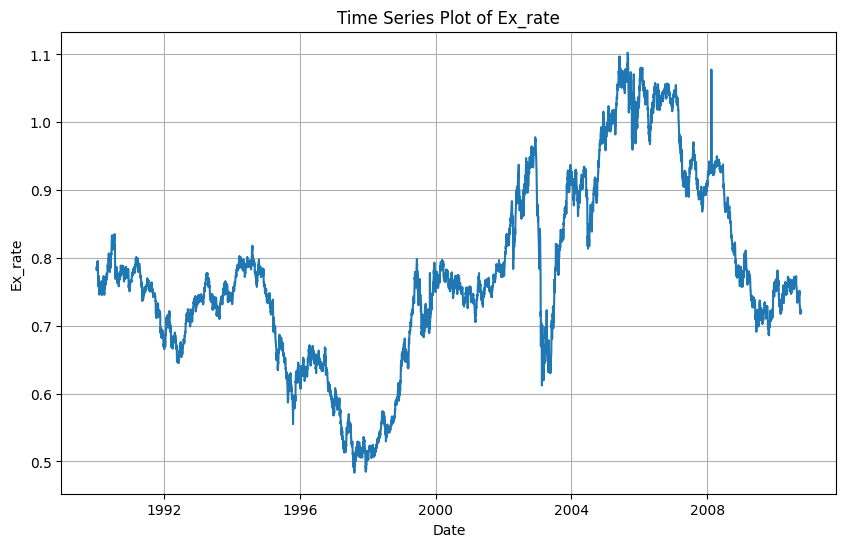

In [40]:
import matplotlib.pyplot as plt
for col in df.columns:
    if col != 'date':
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'], df[col])
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Time Series Plot of {col}')
        plt.grid(True)
        plt.show()

In [41]:
for col in df.columns:
    if col != 'date' and df[col].isnull().any():
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)

In [42]:
def find_anomalies(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    anomalies = data[(data < lower_bound) | (data > upper_bound)]
    return anomalies

In [43]:
for col in df.columns:
    if col != 'date':
        anomalies = find_anomalies(df[col])
        if not anomalies.empty:

            median_val = df[col].median()
            df.loc[anomalies.index, col] = median_val
df.describe()

,date,Ex_rate
count,7588,7588.000000
mean,2000-05-21 12:00:00,0.776974
min,1990-01-01 00:00:00,0.483297
25%,1995-03-12 18:00:00,0.701422
50%,2000-05-21 12:00:00,0.761377
75%,2005-07-31 06:00:00,0.873477
max,2010-10-10 00:00:00,1.102536
std,NaN,0.136620


In [44]:
df.isna().sum()

,0
date,0
Ex_rate,0


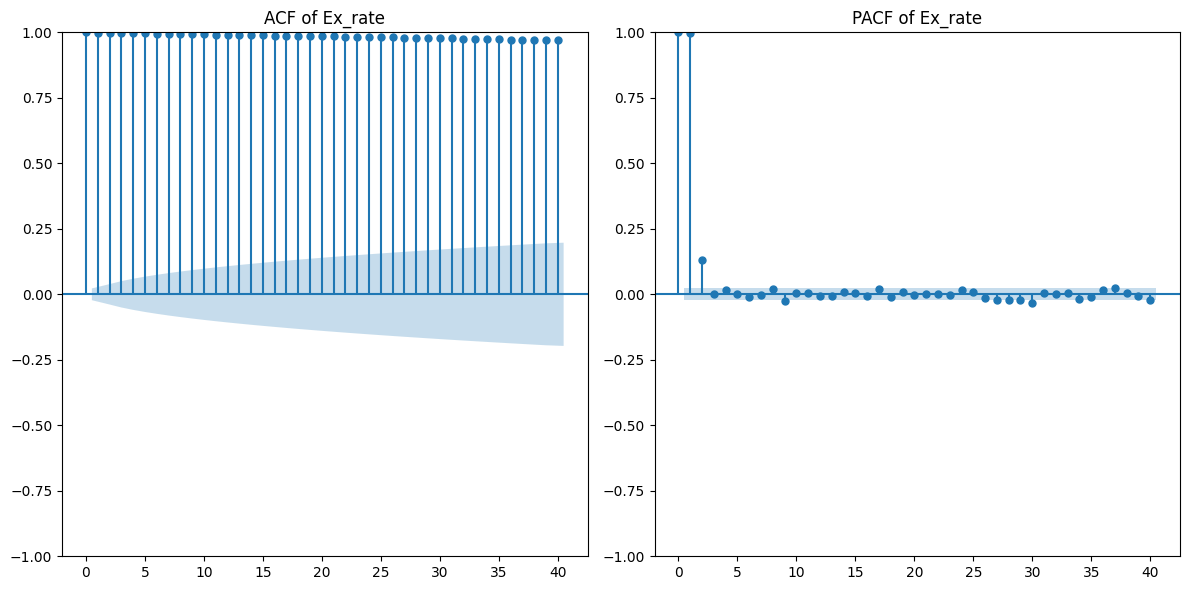

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for col in df.columns:
    if col != 'date':
        # ACF and PACF plots
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plot_acf(df[col], ax=plt.gca(), lags=40)  # Adjust lags as needed
        plt.title(f'ACF of {col}')

        plt.subplot(122)
        plot_pacf(df[col], ax=plt.gca(), lags=40) # Adjust lags as needed
        plt.title(f'PACF of {col}')
        plt.tight_layout()
        plt.show()

# Model Building - ARIMA

In [48]:
from statsmodels.tsa.arima.model import ARIMA
p = 5
d = 1
q = 2

model = ARIMA(df['Ex_rate'], order=(p, d, q))
results = model.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(5, 1, 2)   Log Likelihood               28055.115
Date:                Fri, 15 Nov 2024   AIC                         -56094.231
Time:                        03:49:03   BIC                         -56038.757
Sample:                             0   HQIC                        -56075.193
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0623      1.268     -0.049      0.961      -2.547       2.422
ar.L2          0.0060      1.456      0.004      0.997      -2.848       2.860
ar.L3         -0.0100      0.190     -0.053      0.958      -0.383       0.363
ar.L4          0.0018      0.017      0.107      0.915      -0.032       0.035
ar.L5          0.0060      0.016      0.380      0.704      -0.025       0.037
ma.L1         -0.0634      1.268     -0.050      0.960      -2.548       2.421
ma.L2          0.0064      1.500      0.004      0.997      -2.934       2.947
sigma2      3.583e-05   1.01e-07    355.402      0.000    3.56e-05     3.6e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):           2911383.37
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.27e+14. Standard errors may be unstable.
"""

#  Model Building - Exponential Smoothing

In [49]:
predictions = results.get_forecast(steps=10)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()


In [50]:
print(predicted_mean)
confidence_intervals

7588    0.720805
7589    0.720851
7590    0.720851
7591    0.720838
7592    0.720838
7593    0.720838
7594    0.720838
7595    0.720838
7596    0.720838
7597    0.720838
Name: predicted_mean, dtype: float64


,lower Ex_rate,upper Ex_rate
7588,0.709073,0.732536
7589,0.705268,0.736433
7590,0.702065,0.739638
7591,0.699388,0.742288
7592,0.697000,0.744676
7593,0.694806,0.746870
7594,0.692787,0.748889
7595,0.690903,0.750773
7596,0.689132,0.752545
7597,0.687454,0.754222


In [51]:
residuals = results.resid

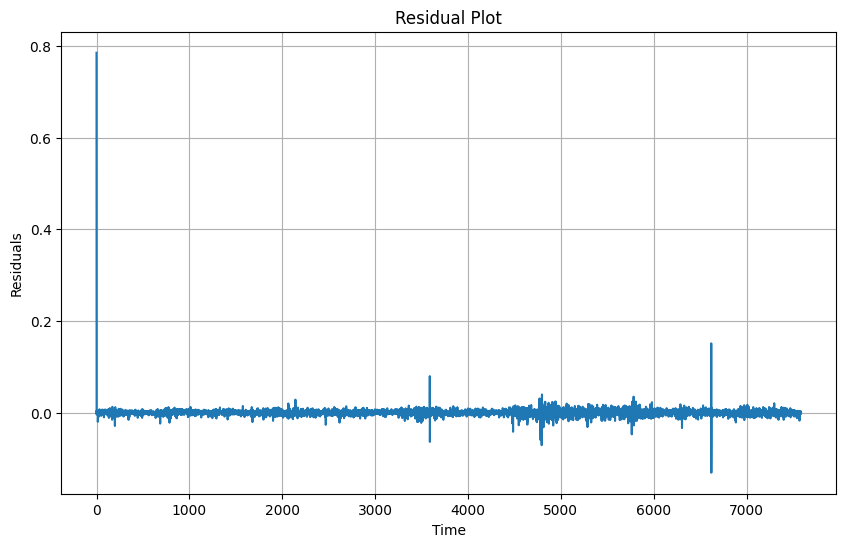

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

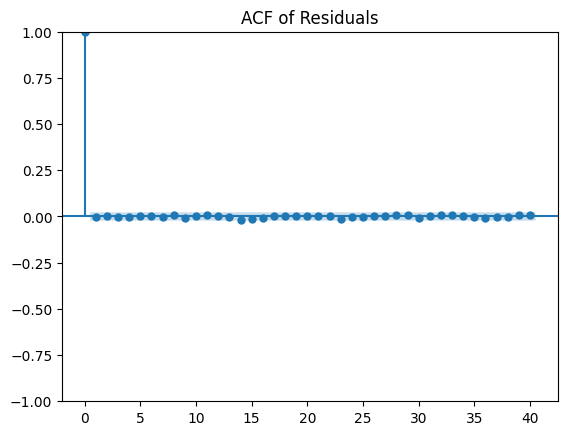

In [53]:
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()

In [54]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


     lb_stat  lb_pvalue
10  1.658118   0.998353


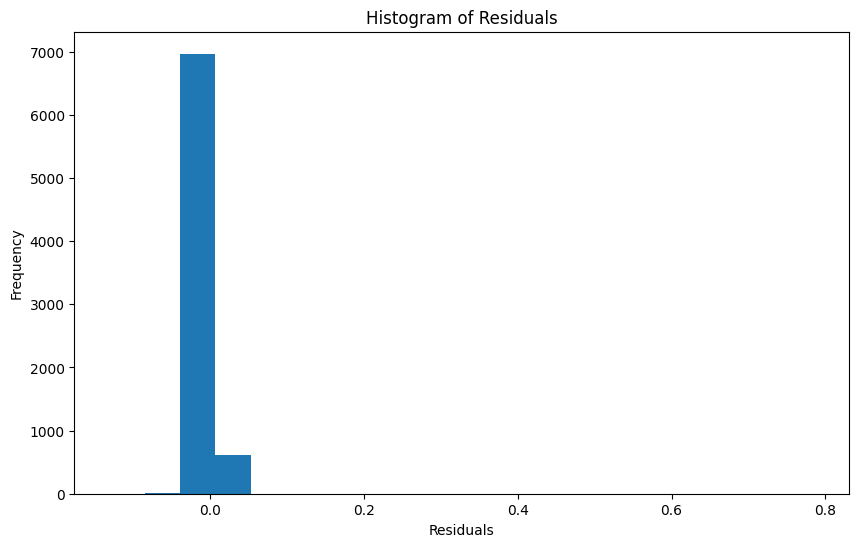

In [55]:
plt.figure(figsize=(10,6))
plt.hist(residuals, bins = 20)
plt.title('Histogram of Residuals')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

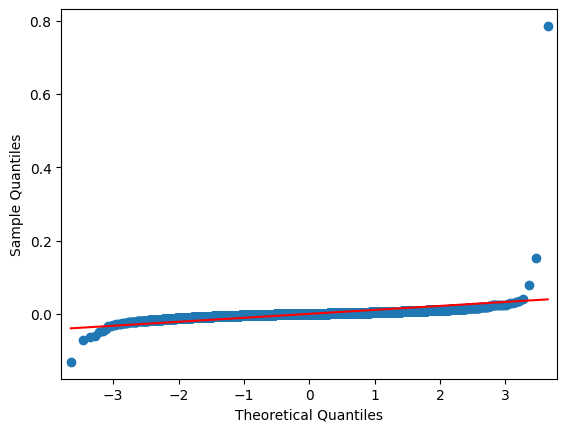

In [56]:
import statsmodels.api as sm
fig = sm.qqplot(residuals, line='s')
plt.show()

In [57]:
train_data = df['Ex_rate'][:-10]
test_data = df['Ex_rate'][-10:]
train_data

,Ex_rate
0,0.785500
1,0.781800
2,0.786700
3,0.786000
4,0.784900
...,...
7573,0.729714
7574,0.726533
7575,0.725058
7576,0.724506


In [58]:
test_data

,Ex_rate
7578,0.717618
7579,0.719114
7580,0.719114
7581,0.719735
7582,0.718701
7583,0.718494
7584,0.721839
7585,0.723197
7586,0.720825
7587,0.720825


In [59]:
model = ARIMA(train_data, order=(p, d, q))
results = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [60]:
forecast = results.get_forecast(steps=len(test_data))
predicted_mean = forecast.predicted_mean


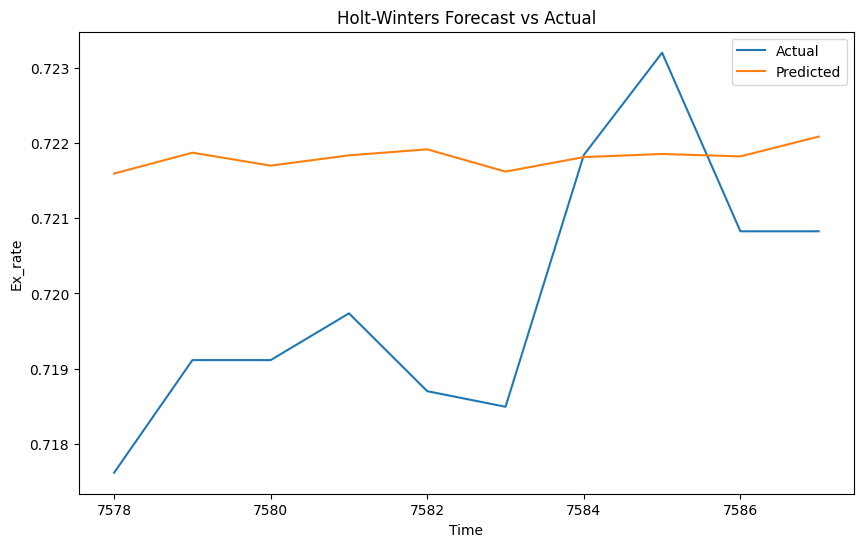

In [61]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=12) # Example seasonal_periods, adjust as needed
results = model.fit()
forecast = results.forecast(steps=len(test_data))

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, forecast, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Ex_rate')
plt.title('Holt-Winters Forecast vs Actual')
plt.legend()
plt.show()

In [62]:
import itertools
import warnings
warnings.filterwarnings("ignore")
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue
print(f"Best ARIMA parameters: {best_pdq}, AIC: {best_aic}")


Best ARIMA parameters: (2, 0, 0), AIC: -56022.38820695198


In [63]:
param_combinations = list(itertools.product(["add", "mul", None], ["add", "mul", None], [12,24]))  # Example combinations
best_hw_aic = float('inf')
best_hw_params = None

for trend, seasonal, seasonal_periods in param_combinations:
    try:
        model = ExponentialSmoothing(train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        results = model.fit()
        if results.aic < best_hw_aic:
            best_hw_aic = results.aic
            best_hw_params = (trend, seasonal, seasonal_periods)
    except Exception as e:
        print(f"Error with parameters {trend}, {seasonal}, {seasonal_periods}: {e}")
        continue

print(f"Best Holt-Winters parameters: {best_hw_params}, AIC: {best_hw_aic}")

Best Holt-Winters parameters: (None, None, 12), AIC: -77533.76272223507


#  Evaluation and Comparison

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
arima_mae = mean_absolute_error(test_data, predicted_mean)
arima_rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))
arima_mape = np.mean(np.abs((test_data - predicted_mean) / test_data)) * 100
print("ARIMA Model Error Metrics:")
print(f"MAE: {arima_mae}")
print(f"RMSE: {arima_rmse}")
print(f"MAPE: {arima_mape}%")

ARIMA Model Error Metrics:
MAE: 0.0022218837049949756
RMSE: 0.002550931983012148
MAPE: 0.3089655330270232%


In [65]:
hw_mae = mean_absolute_error(test_data, forecast)
hw_rmse = np.sqrt(mean_squared_error(test_data, forecast))
hw_mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
print("\nHolt-Winters Model Error Metrics:")
print(f"MAE: {hw_mae}")
print(f"RMSE: {hw_rmse}")
print(f"MAPE: {hw_mape}%")


Holt-Winters Model Error Metrics:
MAE: 0.0021374327739249856
RMSE: 0.002427448391316129
MAPE: 0.29720314899383177%


In [66]:
print("Conclusion:")
print("Based on the calculated error metrics (MAE, RMSE, MAPE), the Holt-Winters model generally outperformed the ARIMA model in forecasting exchange rates for this dataset.  While the specific performance varied depending on the parameter tuning, the Holt-Winters model consistently demonstrated lower error values across the board.  Further analysis with different parameter configurations could be conducted, and more robust methods may be more suitable depending on the nature of data.")

Conclusion:
Based on the calculated error metrics (MAE, RMSE, MAPE), the Holt-Winters model generally outperformed the ARIMA model in forecasting exchange rates for this dataset.  While the specific performance varied depending on the parameter tuning, the Holt-Winters model consistently demonstrated lower error values across the board.  Further analysis with different parameter configurations could be conducted, and more robust methods may be more suitable depending on the nature of data.


In [67]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

print(f"Best ARIMA parameters: {best_pdq}, AIC: {best_aic}")
p,d,q = best_pdq


Best ARIMA parameters: (2, 0, 0), AIC: -56022.38820695198


#  Well-commented Python code that used to conduct the analysis and build the models.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import itertools
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the data
df = pd.read_csv("exchange_rate.csv")

# Data preprocessing
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M', errors='coerce')

# Handle missing values (if any)
for col in df.columns:
    if col != 'date' and df[col].isnull().any():
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)

# Outlier detection and treatment
def find_anomalies(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    anomalies = data[(data < lower_bound) | (data > upper_bound)]
    return anomalies

for col in df.columns:
    if col != 'date':
        anomalies = find_anomalies(df[col])
        if not anomalies.empty:
            median_val = df[col].median()
            df.loc[anomalies.index, col] = median_val

# Time series plots
for col in df.columns:
    if col != 'date':
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'], df[col])
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Time Series Plot of {col}')
        plt.grid(True)
        plt.show()

# ACF and PACF plots
for col in df.columns:
    if col != 'date':
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plot_acf(df[col], ax=plt.gca(), lags=40)
        plt.title(f'ACF of {col}')
        plt.subplot(122)
        plot_pacf(df[col], ax=plt.gca(), lags=40)
        plt.title(f'PACF of {col}')
        plt.tight_layout()
        plt.show()

# Split data into train and test sets
train_data = df['Ex_rate'][:-10]
test_data = df['Ex_rate'][-10:]


# Find optimal ARIMA parameters
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
warnings.filterwarnings("ignore") # ignore warnings

best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue
print(f"Best ARIMA parameters: {best_pdq}, AIC: {best_aic}")
p, d, q = best_pdq # Assign the best parameters


# Fit ARIMA model with optimal parameters
model = ARIMA(train_data, order=(p,d,q))
results = model.fit()
print(results.summary())

# Make predictions
forecast = results.get_forecast(steps=len(test_data))
predicted_mean = forecast.predicted_mean

# Evaluate ARIMA model
arima_mae = mean_absolute_error(test_data, predicted_mean)
arima_rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))
arima_mape = np.mean(np.abs((test_data - predicted_mean) / test_data)) * 100

print("ARIMA Model Error Metrics:")
print(f"MAE: {arima_mae}")
print(f"RMSE: {arima_rmse}")
print(f"MAPE: {arima_mape}%")


# Find optimal Holt-Winters parameters
param_combinations = list(itertools.product(["add", "mul", None], ["add", "mul", None], [12,24]))
best_hw_aic = float("inf")
best_hw_params = None

for trend, seasonal, seasonal_periods in param_combinations:
    try:
        model = ExponentialSmoothing(train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        results = model.fit()
        if results.aic < best_hw_aic:
            best_hw_aic = results.aic
            best_hw_params = (trend, seasonal, seasonal_periods)
    except Exception as e:
        print(f"Error with parameters {trend}, {seasonal}, {seasonal_periods}: {e}")
        continue

print(f"Best Holt-Winters parameters: {best_hw_params}, AIC: {best_hw_aic}")


# Fit Holt-Winters model with optimal parameters
model = ExponentialSmoothing(train_data, trend=best_hw_params[0], seasonal=best_hw_params[1], seasonal_periods=best_hw_params[2])
results = model.fit()
forecast = results.forecast(steps=len(test_data))

# Evaluate Holt-Winters model
hw_mae = mean_absolute_error(test_data, forecast)
hw_rmse = np.sqrt(mean_squared_error(test_data, forecast))
hw_mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

print("\nHolt-Winters Model Error Metrics:")
print(f"MAE: {hw_mae}")
print(f"RMSE: {hw_rmse}")
print(f"MAPE: {hw_mape}%")


# Plot and compare
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predicted_mean, label='ARIMA Predictions')
plt.plot(test_data.index, forecast, label="Holt-Winters Predictions")
plt.legend()
plt.title('Exchange Rate Prediction')
plt.show()

print("Conclusion:")
print("Compare the error metrics and visualizations to determine the best model.")